In [45]:
import os
import pickle
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# import os
# import pickle
# import random
# import pandas as pd
# from itertools import chain
# from tqdm import tqdm
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# import scipy
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer

# from matplotlib import pyplot as plt
# import seaborn as sns

In [3]:
random.seed(2022)

### Loading data

In [4]:
# load part-of-speech triplets and function words;
# they will later be used as features

POS_TRIGRAMS = pickle.load(open('english/pos_trigrams.pkl', 'rb'))
FUNCTION_WORDS = pickle.load(open('english/function_words.pkl', 'rb'))

In [5]:
toefl_dir = "../data/toefl/"
locness_dir = "../data/locness/"

toefl_meta = "/home/uliana/Dropbox/Projects/EFL/TOEFL/TOEFL/data/index.csv"

In [6]:
# read metadata of the TOEFL corpus
metadata = pd.read_csv(toefl_meta)

In [7]:
# load texts from the TOEFL corpus

metadata['Filename'] = toefl_dir + metadata['Filename']
by_level = metadata.groupby('Score Level')

files_high = metadata.loc[by_level.groups['high'], 'Filename']
files_medium = metadata.loc[by_level.groups['medium'], 'Filename']
files_low = metadata.loc[by_level.groups['low'], 'Filename']

In [8]:
# load texts from the LOCNESS corpus
files_native = os.listdir(locness_dir)
files_native = [locness_dir + file for file in files_native]

In [9]:
print(f"Number of essays for level NATIVE: {len(files_native)}.")
print(f"Number of essays for level HIGH: {len(files_high)}.")
print(f"Number of essays for level MEDIUM: {len(files_medium)}.")
print(f"Number of essays for level LOW: {len(files_low)}.")

Number of essays for level NATIVE: 412.
Number of essays for level HIGH: 4202.
Number of essays for level MEDIUM: 6568.
Number of essays for level LOW: 1330.


In [10]:
def read_sentences(files):
    for file in files:
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    yield line.split()

In [11]:
sentences = {
    "high": list(read_sentences(files_high)),
    "medium": list(read_sentences(files_medium)),
    "low": list(read_sentences(files_low)),
    "native": list(read_sentences(files_native))
}

In [12]:
for level in sentences:
    print(f"Number of sentences for level {level.upper()}: {len(sentences[level])}.")

Number of sentences for level HIGH: 75027.
Number of sentences for level MEDIUM: 104431.
Number of sentences for level LOW: 15363.
Number of sentences for level NATIVE: 16235.


## Preparing data for classification

### Create and shuffle chunks

In [13]:
def create_chunks(sents):
    chunks = []
    word_count = 0
    chunk = []
    
    for sent in sents:
        if word_count >= 1000:
            chunks.append(chunk)
            chunk = []
            word_count = 0
        chunk.extend(sent)
        word_count += len(sent)
    return chunks

In [14]:
for level in sentences:
    random.shuffle(sentences[level])

In [15]:
chunks_low = create_chunks(sentences['low'])
chunks_medium = create_chunks(sentences['medium'])
chunks_high = create_chunks(sentences['high'])
chunks_native = create_chunks(sentences['native'])

In [16]:
print(f"Number of chunks for level NATIVE: {len(chunks_native)}.")
print(f"Number of chunks for level HIGH: {len(chunks_high)}.")
print(f"Number of chunks for level MEDIUM: {len(chunks_medium)}.")
print(f"Number of chunks for level LOW: {len(chunks_low)}.")

Number of chunks for level NATIVE: 324.
Number of chunks for level HIGH: 1523.
Number of chunks for level MEDIUM: 2005.
Number of chunks for level LOW: 272.


## Extract features

In [17]:
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
def get_function_words(chunk):
    words = [word.split("_")[0] for word in chunk]
    words = [word for word in words if word in FUNCTION_WORDS]
    return " ".join(words)

def get_pos(chunk):
    words = [word.split("_")[1] for word in chunk]
    return " ".join(words)

def get_labels(label, chunks):
    return [label for i in range(len(chunks))]

In [19]:
# create a vector of labels for each class
labels = (["low"] * len(chunks_low) +
          ["med"] * len(chunks_medium) +
          ["high"] *len(chunks_high) +
          ["nat"] * len(chunks_native))

In [20]:
# for each chunk, create feature vectors where dimensions
# correspond to function words and PoS trigrams
fw_vectors = []
pos_vectors = []

for chunk in chunks_low + chunks_medium + chunks_high + chunks_native:
    fw = get_function_words(chunk)
    fw_vectors.append(fw)
    
    pos = get_pos(chunk)
    pos_vectors.append(pos)

In [21]:
# perform TF-IDF transformation on function words vectors
fw_vectorizer = TfidfVectorizer()
fw_vectorizer.fit(fw_vectors)
fw_corpus = fw_vectorizer.transform(fw_vectors)
fw_corpus

<4124x375 sparse matrix of type '<class 'numpy.float64'>'
	with 469364 stored elements in Compressed Sparse Row format>

In [22]:
fw_vectorizer.get_feature_names_out()[:20]

array(['about', 'above', 'accordingly', 'actual', 'actually', 'after',
       'afterward', 'afterwards', 'again', 'against', 'ago', 'all',
       'almost', 'along', 'already', 'also', 'although', 'always', 'am',
       'among'], dtype=object)

In [23]:
# perform TF-IDF transformation on PoS vectors

pos_vectorizer = TfidfVectorizer(ngram_range=(3,3))
pos_vectorizer.fit(pos_vectors)
pos_corpus = pos_vectorizer.transform(pos_vectors)
pos_corpus

<4124x2840 sparse matrix of type '<class 'numpy.float64'>'
	with 1576115 stored elements in Compressed Sparse Row format>

In [24]:
print(pos_vectorizer.get_feature_names_out())

['adj adj adj' 'adj adj adp' 'adj adj adv' ... 'verb verb propn'
 'verb verb sconj' 'verb verb verb']


In [25]:
# for each chunk, combine two vectors into one
corpus = scipy.sparse.hstack([fw_corpus, pos_corpus], format='csr')
corpus

<4124x3215 sparse matrix of type '<class 'numpy.float64'>'
	with 2045479 stored elements in Compressed Sparse Row format>

In [26]:
print(f"Total number of chunks: {corpus.shape[0]}.")
print(f"Total number of features: {corpus.shape[1]}.")

Total number of chunks: 4124.
Total number of features: 3215.


### Applying different strategies for imbalanced data

#### Prepare labels

In [27]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

In [28]:
labels_counter = Counter(labels)

print("Number of observations per class:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

Number of observations per class:
	low	272
	med	2005
	high	1523
	nat	324


#### Create one class for non-native essays

In [29]:
y = np.array(labels)
y[np.where(y != "nat")] = "nnat"

labels_counter = Counter(y)
print("Number of observations per class:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

Number of observations per class:
	nnat	3800
	nat	324


#### Oversampling

In [30]:
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(corpus, y)

In [31]:
labels_counter = Counter(y_resampled)
print("Number of observations per class after oversampling:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

Number of observations per class after oversampling:
	nnat	3800
	nat	3800


#### Undersampling

In [ ]:
undersample = ClusterCentroids(random_state=2022)
X_resampled, y_resampled = undersample.fit_resample(corpus, y)

labels_counter = Counter(y_resampled)
print("Number of observations per class after undersampling:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

#### Undersampling + oversampling

First, reduce the number of non-native essays by downsampling them to the smallest class (class `low`).

Then, oversample native essays to the number of non-native essays.

In [ ]:
undersample = RandomUnderSampler(random_state=2022)
# undersample = ClusterCentroids(random_state=2022)

X_resampled, y_resampled = undersample.fit_resample(corpus, labels)

In [ ]:
labels_counter = Counter(y_resampled)

print("Number of observations per class after undersampling:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

In [ ]:
y_resampled = np.array(y_resampled)
y_resampled[np.where(y_resampled != 'nat')] = 'nnat'

labels_counter = Counter(y_resampled)
print("Number of observations per class after undersampling non-native essays:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

In [ ]:
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_resampled, y_resampled)

labels_counter = Counter(y_resampled)
print("Number of observations per class after oversampling native essays:")
for key in labels_counter:
    print(f"\t{key}\t{labels_counter[key]}")

## Classification

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [33]:
fold = StratifiedShuffleSplit(n_splits=10, test_size=0.4, random_state=0)
clf = LogisticRegression()

for train_idx, test_idx in fold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: = {:.3f}".format(clf.score(X_test, y_test)), end=' \t')
    print("F-score = {:.3f}".format(f1_score(y_test, y_pred, average='micro')))

Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 0.999 	F-score = 0.999
Accuracy: = 0.999 	F-score = 0.999
Accuracy: = 0.999 	F-score = 0.999
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000


In [34]:
fold = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
clf = LinearSVC()

for train_idx, test_idx in fold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: = {:.3f}".format(clf.score(X_test, y_test)), end=' \t')
    print("F-score = {:.3f}".format(f1_score(y_test, y_pred, average='micro')))

Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000
Accuracy: = 1.000 	F-score = 1.000


In [35]:
def get_distance(clf, point):
    dfunc = clf.decision_function(point)
    w_norm = np.linalg.norm(clf.coef_)
    dist = dfunc / w_norm
    return dist

In [36]:
orig_y = np.array(labels)

In [37]:
points_low = corpus[np.where(orig_y == "low")]
dist = get_distance(clf, points_low)
print("Proficiency level: low\n----------------------")
print(f"Median distance from hyperplane: {np.median(dist).round(4)}")
print(f"Mean distance from hyperplane: {np.mean(dist).round(4)}")
print("MAD:", scipy.stats.median_abs_deviation(dist).round(4))

Proficiency level: low
----------------------
Median distance from hyperplane: 0.2013
Mean distance from hyperplane: 0.2012
MAD: 0.0247


In [38]:
points_med = corpus[np.where(orig_y == "med")]
dist = get_distance(clf, points_med)
print("Proficiency level: medium\n-------------------------")
print(f"Median distance from hyperplane: {np.median(dist).round(4)}")
print(f"Mean distance from hyperplane: {np.mean(dist).round(4)}")
print("MAD:", scipy.stats.median_abs_deviation(dist).round(4))

Proficiency level: medium
-------------------------
Median distance from hyperplane: 0.1875
Mean distance from hyperplane: 0.1875
MAD: 0.0227


In [39]:
points_high = corpus[np.where(orig_y == "high")]
dist = get_distance(clf, points_high)
print("Proficiency level: high\n-----------------------")
print(f"Median distance from hyperplane: {np.median(dist).round(4)}")
print(f"Mean distance from hyperplane: {np.mean(dist).round(4)}")
print("MAD:", scipy.stats.median_abs_deviation(dist).round(4))

Proficiency level: high
-----------------------
Median distance from hyperplane: 0.1481
Mean distance from hyperplane: 0.1486
MAD: 0.0229


In [40]:
points_nat = corpus[np.where(orig_y == "nat")]
dist = get_distance(clf, points_nat)
print("Proficiency level: native\n-------------------------")
print(f"Median distance from hyperplane: {np.median(dist).round(4)}")
print(f"Mean distance from hyperplane: {np.mean(dist).round(4)}")
print("MAD:", scipy.stats.median_abs_deviation(dist).round(4))

Proficiency level: native
-------------------------
Median distance from hyperplane: -0.1395
Mean distance from hyperplane: -0.1444
MAD: 0.0255


## Distribution of distances

In [41]:
distances = get_distance(clf, corpus)
distances_df = pd.DataFrame(data=zip(distances, labels), columns=['distance', 'level'])
distances_df.head()

,distance,level
0,0.240546,low
1,0.183087,low
2,0.239364,low
3,0.172792,low
4,0.161318,low


In [42]:
# apply colors for each level
COLORS = {
    "low": 'red',
    'med': 'yellow',
    'high': 'green',
    'nat': 'blue'
}
distances_df['color'] = distances_df['level'].map(COLORS)

In [43]:
# creating a subset of non-native speakers
nonnatives = distances_df[distances_df['level'] != 'nat']

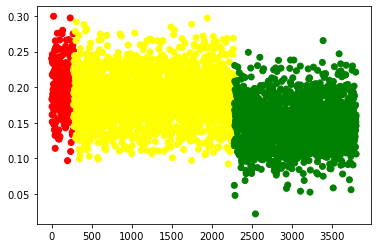

In [46]:
# sns.scatterplot(x=range(len(nonnatives)),
#                 y=nonnatives["distance"],
#                 c=nonnatives["color"], marker='o')
fig, ax = plt.subplots()
ax.scatter(x=range(len(nonnatives)), y=nonnatives["distance"], c=nonnatives["color"])

<AxesSubplot:xlabel='level', ylabel='distance'>

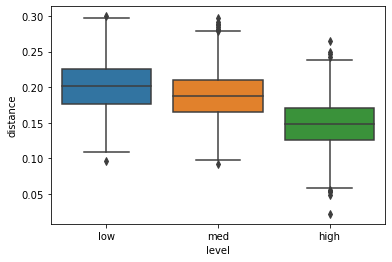

In [47]:
sns.boxplot(x='level', y='distance', data=nonnatives)

## Distribution of `distance`

<AxesSubplot:xlabel='distance', ylabel='Count'>

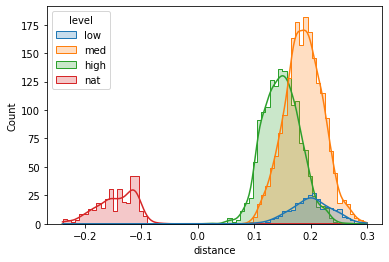

In [62]:
sns.histplot(x='distance', data=distances_df, hue='level', kde=True, element='step')

In [63]:
nonatives = distances_df[distances_df['level'].isin(['low', 'med', 'high'])]

<AxesSubplot:xlabel='distance', ylabel='Count'>

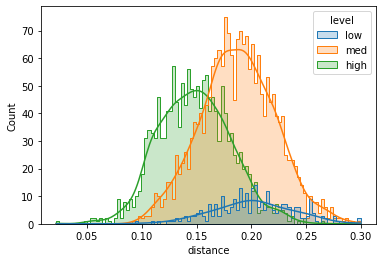

In [64]:
sns.histplot(x='distance', data=nonnatives, hue='level', kde=True,
             element='step', bins=100)

<AxesSubplot:xlabel='distance', ylabel='Count'>

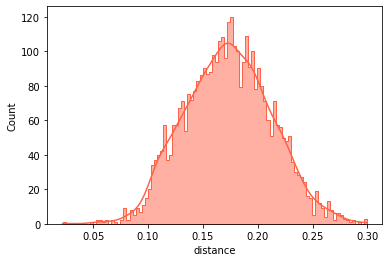

In [65]:
sns.histplot(x='distance', data=nonnatives, kde=True, element='step', bins=100, color='tomato')

## Clustering

In [66]:
# for each chunk, get distances from the hyperplane 
low_dist = get_distance(clf, points_low)
med_dist = get_distance(clf, points_med)
high_dist = get_distance(clf, points_high)
nat_dist = get_distance(clf, points_nat)

In [67]:
# calculate mean distance for each level
low_centroid = np.mean(low_dist)
high_centroid = np.mean(high_dist)
med_centroid = np.mean(med_dist)

In [68]:
pred_centroid = []

for i, row in distances_df.iterrows():
    dist = row['distance']
    
    dist_dict = {
        'high': abs(high_centroid - dist),
        'med': abs(med_centroid - dist),
        'low': abs(low_centroid - dist)
    }
    max_centroid = sorted(dist_dict, key=lambda x: dist_dict[x])[0]
    pred_centroid.append(max_centroid)

In [69]:
distances_df['pred centroid'] = pred_centroid

In [70]:
print("Overall accuracy of the approach: {:.2%}".format(
    accuracy_score(distances_df['level'], distances_df['pred centroid'])))

Overall accuracy of the approach: 45.34%


In [71]:
high_df = distances_df[distances_df['level'] == 'high']
print("Accuracy for level HIGH: {:.2%}".format(
    accuracy_score(high_df['level'], high_df['pred centroid'])))

Accuracy for level HIGH: 72.29%


In [72]:
med_df = distances_df[distances_df['level'] == 'med']
print("Accuracy for level MEDIUM: {:.2%}".format(
    accuracy_score(med_df['level'], med_df['pred centroid'])))

Accuracy for level MEDIUM: 30.42%


In [73]:
low_df = distances_df[distances_df['level'] == 'low']
print("Accuracy for level LOW: {:.2%}".format(
    accuracy_score(low_df['level'], low_df['pred centroid'])))

Accuracy for level LOW: 58.46%


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(edges['level'], edges['pred centroid']))

- use the same classifier on individual essays; -> different results clustering them
- train the classifier on individual essays; -> predict on individual essays (native language control)
- repeat the same experiment on the German-speakers corpus
- repeat the same experiment on hebrew speakers

## Testing classifier on individual essays

In [ ]:
essays_high = []
for file in files_high:
    with open(toefl_dir + file, 'r') as f:
        essays_high.append(f.read().strip().replace("\n", " "))
print(f"Number of essays on high level: {len(essays_high)}")

In [ ]:
essays_medium = []
for file in files_medium:
    with open(toefl_dir + file, 'r') as f:
        essays_medium.append(f.read().strip().replace("\n", " "))
print(f"Number of essays on medium level: {len(essays_medium)}")

In [ ]:
essays_low = []
for file in files_low:
    with open(toefl_dir + file, 'r') as f:
        essays_low.append(f.read().strip().replace("\n", " "))
print(f"Number of essays on low level: {len(essays_low)}")

In [ ]:
essays_nat = []
for file in files_native:
    with open(locness_dir + file, 'r') as f:
        essays_nat.append(f.read().strip().replace("\n", " "))
print(f"Number of essays on native level: {len(essays_nat)}")

In [ ]:
labels = (["low"] * len(essays_low) +
          ["med"] * len(essays_medium) +
          ["high"] * len(essays_high))
print(len(labels))

In [ ]:
fw_vectors = []
pos_vectors = []

for essay in essays_low + essays_medium + essays_high:
    fw = get_function_words(essay.split())
    fw_vectors.append(fw)
    
    pos = get_pos(essay.split())
    pos_vectors.append(pos)

In [ ]:
len(fw_vectors), len(pos_vectors)

#### Transform with the same vectorizer

In [ ]:
print(len(fw_vectorizer.get_feature_names_out()))
print(len(pos_vectorizer.get_feature_names_out()))

In [ ]:
fw_corpus_essays = fw_vectorizer.transform(fw_vectors)

In [ ]:
pos_corpus_essays = pos_vectorizer.transform(pos_vectors)

In [ ]:
new_corpus = scipy.sparse.hstack([fw_corpus_essays, pos_corpus_essays], format='csr')
new_corpus

### Make predictions: native vs nonnative

In [ ]:
y_pred = clf.predict(new_corpus)
y_true = ['nnat'] * len(labels)

In [ ]:
print(f"accuracy on individual essays: {accuracy_score(y_true, y_pred):.2%}")

### Clustering

In [ ]:
distances = get_distance(clf, new_corpus)
distances_df = pd.DataFrame(data=zip(distances, labels), columns=['distance', 'level'])
distances_df.head()

In [ ]:
# apply colors for each level
COLORS = {
    "low": 'red',
    'med': 'yellow',
    'high': 'green',
    'nat': 'blue'
}
distances_df['color'] = distances_df['level'].map(COLORS)

In [ ]:
# creating a subset of non-native speakers
nonnatives = distances_df[distances_df['level'] != 'nat']

# sns.scatterplot(x=range(len(nonnatives)),
#                 y=nonnatives["distance"],
#                 c=nonnatives["color"], marker='o')
fig, ax = plt.subplots()
ax.scatter(x=range(len(nonnatives)), y=nonnatives["distance"], c=nonnatives["color"])

In [ ]:
sns.boxplot(x='level', y='distance', data=nonnatives)

In [ ]:
pred_centroid = []

for i, row in distances_df.iterrows():
    dist = row['distance']
    
    dist_dict = {
        'high': abs(high_centroid - dist),
        'med': abs(med_centroid - dist),
        'low': abs(low_centroid - dist)
    }
    max_centroid = sorted(dist_dict, key=lambda x: dist_dict[x])[0]
    pred_centroid.append(max_centroid)
distances_df['pred centroid'] = pred_centroid

In [ ]:
print("Overall accuracy of the approach: {:.2%}".format(
    accuracy_score(distances_df['level'], distances_df['pred centroid'])))

In [ ]:
high_df = distances_df[distances_df['level'] == 'high']
print("Accuracy for high level: {:.2%}".format(
    accuracy_score(high_df['level'], high_df['pred centroid'])))

In [ ]:
med_df = distances_df[distances_df['level'] == 'med']
print("Accuracy for high level: {:.2%}".format(
    accuracy_score(med_df['level'], med_df['pred centroid'])))

In [ ]:
low_df = distances_df[distances_df['level'] == 'low']
print("Accuracy for high level: {:.2%}".format(
    accuracy_score(low_df['level'], low_df['pred centroid'])))

In [ ]:
print(classification_report(distances_df['level'], distances_df['pred centroid']))